In [1]:
import numpy as np
from collections import defaultdict
import random
from tqdm import trange
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import igraph
from matplotlib import cm, colors
random.seed(42)
import seaborn as sns
from testing_environments import ContinuousTMaze, GridEnv,GridEnvRightDownNoCue, GridEnvRightDownNoSelf, GridEnvDivergingMultipleReward, GridEnvDivergingSingleReward
from util import *

In [5]:
def stationary_distribution_eig(P):
    """
    Computes the stationary distribution of transition matrix P
    by solving P^T * v = v, and normalizing v so sum(v)=1.

    Parameters
    ----------
    P : 2D np.ndarray, shape (N, N)
        Transition matrix of a Markov chain (rows sum to 1).

    Returns
    -------
    z : 1D np.ndarray, shape (N,)
        The stationary distribution (row vector) such that zP = z.
    """
    # Eigen-decomposition of P^T
    eigenvalues, eigenvectors = np.linalg.eig(P.T)

    # Find index of eigenvalue 1 (within a numerical tolerance)
    idx = np.argmin(np.abs(eigenvalues - 1.0))

    # The corresponding eigenvector
    v = np.real(eigenvectors[:, idx])  # ensure it's real

    # Normalize so that it sums to 1
    # We also make sure all entries are non-negative (small numerical errors can introduce tiny negatives)
    v = np.where(v < 0, 0, v)  # clip negative values to 0 if needed
    if np.sum(v) == 0:
        raise ValueError("No non-negative eigenvector found corresponding to eigenvalue 1.")
    z = v / np.sum(v)

    return z

def stationary_distribution_power(P, max_iter=1000, tol=1e-12):
    """
    Computes the stationary distribution of transition matrix P
    by repeated multiplication (power iteration).

    Parameters
    ----------
    P : 2D np.ndarray, shape (N, N)
        Transition matrix of a Markov chain (rows sum to 1).
    max_iter : int
        Maximum number of iterations.
    tol : float
        Convergence tolerance (on L1 or L2 difference).

    Returns
    -------
    z : 1D np.ndarray, shape (N,)
        The stationary distribution (row vector).
    """
    N = P.shape[0]
    # Start from a uniform distribution (or random)
    z = np.ones(N) / N  

    for _ in range(max_iter):
        z_next = z @ P  # matrix multiplication from the left
        # Check convergence by comparing difference
        if np.linalg.norm(z_next - z, 1) < tol:
            break
        z = z_next

    # Normalize (just in case of tiny drift)
    z /= np.sum(z)
    return z
def row_normalize(matrix):
    """
    Returns a row-normalized copy of 'matrix'.
    Each row of the result sums to 1.
    """
    # Convert to float to avoid integer division issues
    matrix = matrix.astype(float)
    
    # Sum over columns, keep dimension for broadcasting
    row_sums = matrix.sum(axis=1, keepdims=True)

    # Avoid division by zero by replacing zeros with 1.0
    row_sums[row_sums == 0] = 1.0
    
    # Divide each row by its sum
    normalized = matrix / row_sums
    
    return normalized

In [28]:
size = 4
env_size = (size,size)
rewarded_terminal = env_size[0]*env_size[1]
cue_states = [6]
# env = GridEnvRightDownNoSelf(env_size=env_size, 
#                              rewarded_terminal = [rewarded_terminal],
#                              cue_states=cue_states)
env = GridEnv(env_size=env_size, 
                             rewarded_terminal = [rewarded_terminal],
                             cue_states=cue_states)
# env = GridEnvRightDownNoSelf(cue_states=[6])

n_episodes = 1000
max_steps_per_episode = 100

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)

In [29]:
P = transition_matrix(dataset)

# P = P[1:, 1:]

P = row_normalize(P)


<Axes: >

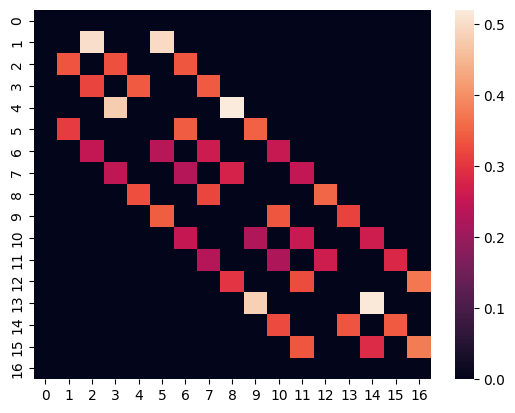

In [30]:
sns.heatmap(P)

In [9]:
# P = np.array([
#     [0.9, 0.1, 0.0],
#     [0.9, 0.0, 0.1],
#     [1.0, 0.0, 0.0]
# ])

z = stationary_distribution_eig(P)
print("Stationary distribution (via eigenvector):", z)

Stationary distribution (via eigenvector): [0.         0.02522334 0.03711529 0.0369068  0.03838272 0.025554
 0.03733666 0.05075578 0.05042165 0.04941369 0.03659069 0.0368036
 0.05169152 0.05438299 0.05286184 0.03721302 0.03822621 0.05065738
 0.05334339 0.05012556 0.03044739 0.02465866 0.03770338 0.03851946
 0.02916542 0.02649957]


In [32]:
# if __name__ == "__main__":
# P = np.array([
#     [0.9, 0.1, 0.0],
#     [0.9, 0.0, 0.1],
#     [1.0, 0.0, 0.0]
# ])





z = stationary_distribution_power(P[1:,1:])
print("Stationary distribution (via power iteration):", z)

Stationary distribution (via power iteration): [0.04865179 0.06990964 0.07188271 0.04509675 0.0690627  0.09619543
 0.08661775 0.0656321  0.06823575 0.08265261 0.07699383 0.04254318
 0.04087891 0.05981671 0.04144893 0.03438121]


In [3]:
# P = np.array([
#     [0.9, 0.1, 0.0],
#     [0.9, 0.0, 0.1],
#     [1.0, 0.0, 0.0]
# ])

# z = stationary_distribution_eig(P)
# print("Stationary distribution (via eigenvector):", z)

Stationary distribution (via eigenvector): [0.9009009  0.09009009 0.00900901]


In [22]:
# [[P[0,0]*z[0]/z[0], P[0,1]*z[0]/z[1], P[0,2]*z[0]/z[2]], 
#  [P[1,0]*z[1]/z[0], P[1,1]*z[1]/z[1], P[1,2]*z[1]/z[2]], 
#  [P[2,0]*z[2]/z[0], P[2,1]*z[2]/z[1], P[2,2]*z[2]/z[2]]]

[[0.9, 1.0000000000000002, 0.0],
 [0.09000000000000001, 0.0, 1.0000000000000004],
 [0.009999999999999997, 0.0, 0.0]]

In [33]:
P_r = retrospective_transition_matrix(P[1:,1:], z)


<Axes: >

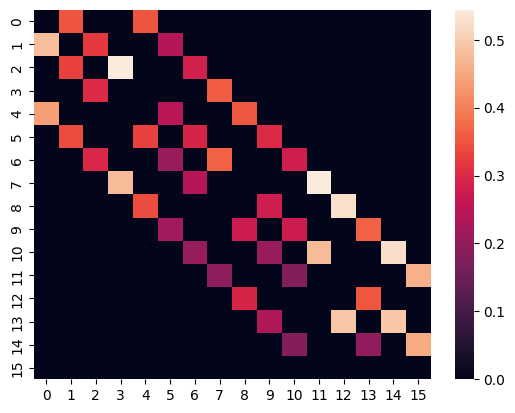

In [34]:
sns.heatmap(P_r)

In [38]:
# import numpy as np
def successor_representation(P, gamma=0.9):
    """
    Compute the Successor Representation (SR) for a Markov chain or MDP 
    given a prospective (forward) transition matrix P and a discount factor gamma.

    SR = (I - gamma*P)^{-1}

    Parameters
    ----------
    P : np.ndarray of shape (n, n)
        The forward (prospective) transition matrix, where P[i,j] 
        is the probability of transitioning from state i to state j.
        Typically, rows sum to 1.
    gamma : float
        The discount factor in [0, 1). Commonly 0.9 or similar.

    Returns
    -------
    SR : np.ndarray of shape (n, n)
        The successor representation matrix.
        SR[i, j] can be interpreted as the expected discounted time 
        spent in state j if you start in state i.
    """
    n = P.shape[0]
    I = np.eye(n)
    # Compute (I - gamma * P)^{-1} if it's invertible
    SR = np.linalg.inv(I - gamma * P)
    return SR

def predecessor_representation(P_r, gamma=0.9):
    """
    Compute the predecessor representation for a time-reversed (retrospective)
    transition matrix P_r and discount factor gamma.

    PR = (I - gamma*P_r)^{-1}

    Parameters
    ----------
    P_r : 2D np.ndarray, shape (n, n)
        The time-reversed transition matrix.
    gamma : float
        Discount factor.

    Returns
    -------
    PR : 2D np.ndarray, shape (n, n)
        The predecessor representation matrix.
    """
    n = P_r.shape[0]
    I = np.eye(n)
    # Compute (I - gamma * P_r)^{-1}
    PR = np.linalg.inv(I - gamma * P_r)
    return PR

# -----------------------------------------------------------
# Example usage
# -----------------------------------------------------------
# if __name__ == "__main__":
    # Suppose we have the retrospective transition matrix (approx from your example)
    # This is the "time-reversed" version of the original P_s, with z ~ [0.9009, 0.0901, 0.009].
    # NOTE: The exact numbers may vary slightly based on rounding.
# P_r = np.array([
#     [0.9,   1.0,  0.0],
#     [0.09,  0.0,  1.0],
#     [0.01,  0.0,  1.0]
# ])

gamma = 0.9
PR = predecessor_representation(P_r, gamma)

print("Retrospective transition matrix, P_r:")
print(P_r, "\n")

print(f"Predecessor Representation (gamma={gamma}):")
# Rounded for readability
print(PR.round(2))


Retrospective transition matrix, P_r:
[[0.         0.34980168 0.         0.         0.35036675 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.47977608 0.         0.32084176 0.         0.         0.24434327
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.32799791 0.         0.54241027 0.         0.
  0.28275444 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.30079787 0.         0.         0.
  0.         0.35766924 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.43670549 0.         0.         0.         0.         0.246612
  0.         0.         0.35308844 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.34143427 0.         0.         0.32734334 0.
  0.28948455 0.         0.         0.29816555 0.     

In [35]:
SR = successor_representation(P, gamma)

<Axes: >

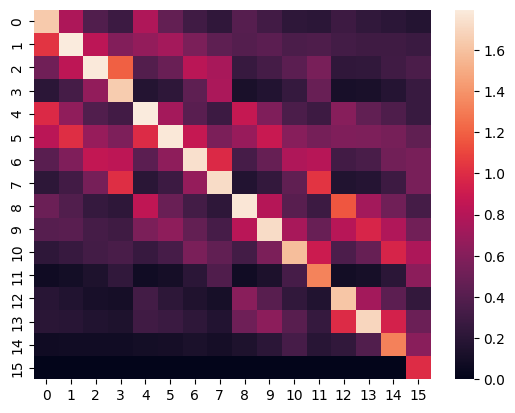

In [39]:
sns.heatmap(PR)

<Axes: >

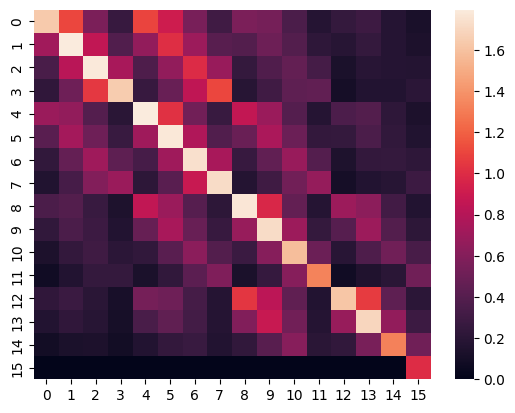

In [40]:
sns.heatmap(SR[1:,1:])

In [22]:
# import numpy as np

def predecessor_representation_contingency(Mp):
    """
    Compute the 'contingency' version of the Predecessor Representation (PR).

    Mp : np.ndarray of shape (n, n)
        The Predecessor Representation matrix.
    
    Returns
    -------
    Mp_cont : np.ndarray of shape (n, n)
        The PR contingency matrix, Mp - (Mp*E)/m.
    """
    n = Mp.shape[0]
    E = np.ones((n, n))
    # Mp * E is shape (n, n), each row i is the sum of row i repeated across columns.
    # Divide by n to get the row average, then subtract from Mp.
    Mp_cont = Mp - (Mp @ E) / n
    return Mp_cont

def successor_representation_contingency(Ms):
    """
    Compute the 'contingency' version of the Successor Representation (SR).

    Ms : np.ndarray of shape (n, n)
        The Successor Representation matrix.

    Returns
    -------
    Ms_cont : np.ndarray of shape (n, n)
        The SR contingency matrix, Ms - (Ms*E)/m.
    """
    n = Ms.shape[0]
    E = np.ones((n, n))
    Ms_cont = Ms - (Ms @ E) / n
    return Ms_cont




In [41]:
# --------------------------------------------------------------------
# Example Usage
# --------------------------------------------------------------------
# if __name__ == "__main__":
    # Example: Suppose we have a 3x3 PR matrix from earlier
# Mp = np.array([
#     [ 9.01,  9.11,  8.20],
#     [ 0.90,  0.81,  1.73],
#     [ 0.09,  0.08,  0.07]
# ])
Mp = PR
# And an example SR matrix (made-up values)
# Ms = np.array([
#     [ 1.2,  1.0,  0.8],
#     [ 0.1,  1.6,  2.5],
#     [ 0.3,  0.9,  3.1]
# ])
Ms = SR

Mp_cont = predecessor_representation_contingency(Mp)
Ms_cont = successor_representation_contingency(Ms)

print("Predecessor Representation (Mp):")
print(Mp.round(2), "\n")

print("Mp contingency = Mp - (Mp*E)/n :")
print(Mp_cont.round(2), "\n")

print("Successor Representation (Ms):")
print(Ms.round(2), "\n")

print("Ms contingency = Ms - (Ms*E)/n :")
print(Ms_cont.round(2))


Predecessor Representation (Mp):
[[1.64 0.77 0.38 0.28 0.77 0.46 0.31 0.23 0.4  0.32 0.22 0.21 0.29 0.23
  0.21 0.17]
 [1.04 1.8  0.83 0.59 0.66 0.73 0.56 0.44 0.4  0.43 0.36 0.37 0.32 0.29
  0.3  0.28]
 [0.51 0.84 1.78 1.19 0.39 0.49 0.82 0.75 0.26 0.33 0.43 0.55 0.23 0.23
  0.31 0.35]
 [0.21 0.33 0.66 1.65 0.17 0.22 0.44 0.76 0.12 0.17 0.26 0.48 0.11 0.12
  0.18 0.27]
 [0.98 0.65 0.38 0.31 1.79 0.73 0.42 0.29 0.87 0.58 0.35 0.29 0.61 0.45
  0.37 0.27]
 [0.83 1.01 0.68 0.57 0.99 1.78 0.87 0.56 0.68 0.88 0.62 0.54 0.58 0.57
  0.55 0.45]
 [0.42 0.58 0.86 0.84 0.42 0.64 1.74 0.98 0.33 0.47 0.77 0.81 0.31 0.35
  0.52 0.55]
 [0.22 0.32 0.54 1.   0.2  0.29 0.67 1.72 0.16 0.24 0.44 1.03 0.16 0.18
  0.29 0.55]
 [0.5  0.38 0.25 0.22 0.84 0.49 0.32 0.22 1.77 0.8  0.41 0.28 1.16 0.73
  0.52 0.33]
 [0.4  0.42 0.33 0.3  0.57 0.64 0.46 0.33 0.82 1.72 0.75 0.48 0.81 0.96
  0.78 0.52]
 [0.22 0.26 0.32 0.35 0.26 0.33 0.56 0.45 0.32 0.56 1.58 0.9  0.36 0.47
  0.96 0.77]
 [0.07 0.1  0.15 0.23 0.08 0.1  

<Axes: >

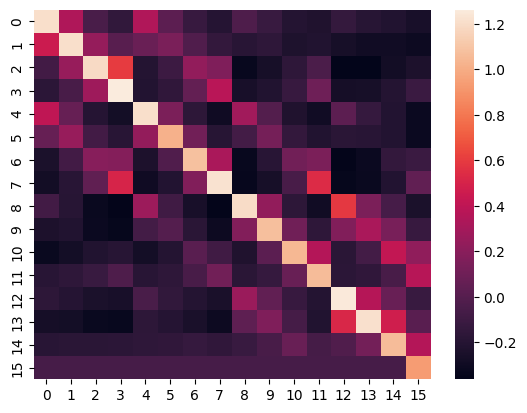

In [42]:
sns.heatmap(Mp_cont)

<Axes: >

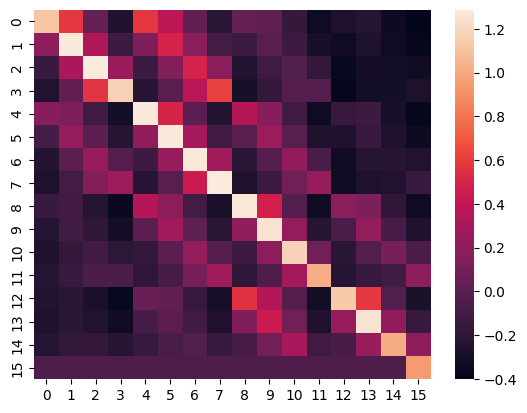

In [43]:
sns.heatmap(Ms_cont[1:,1:])

In [14]:
# P_r_ = np.reshape(P_r, (env_size[0],env_size[1]))
# P_r_ = np.transpose(P_r_)
# sns.heatmap(P_r_)

ValueError: cannot reshape array of size 625 into shape (5,5)